In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
trades = pd.read_csv("/Users/kanhaiya/Downloads/Historical Data.csv")
sentiment = pd.read_csv("/Users/kanhaiya/Downloads/Fear Greed Index.csv")

# Shape
trades.shape
sentiment.shape

# Preview
trades.head(), sentiment.head()

(                                      Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
 3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
 4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   
 
    Closed PnL                                   Transaction Hash     Order ID  \
 0      

In [32]:
print("\nMissing Values (Trades):\n", trades.isnull().sum())
print("\nMissing Values (Sentiment):\n", sentiment.isnull().sum())


Missing Values (Trades):
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Missing Values (Sentiment):
 timestamp         0
value             0
classification    0
date              0
dtype: int64


In [31]:
print("\nDuplicates (Trades):", trades.duplicated().sum())
print("Duplicates (Sentiment):", sentiment.duplicated().sum())


Duplicates (Trades): 0
Duplicates (Sentiment): 0


In [33]:
# Fix timestamp (IMPORTANT)
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], unit='ms', errors='coerce')

# Drop invalid rows
trades = trades.dropna(subset=['Timestamp'])

# Create daily date
trades['date'] = trades['Timestamp'].dt.date

# Sentiment date
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

# Rename columns
trades = trades.rename(columns={
    'Closed PnL': 'closedPnL',
    'Size USD': 'size',
    'Side': 'side',
    'Account': 'account'
})

# Remove duplicates
trades = trades.drop_duplicates()

# Merge datasets
df = pd.merge(trades, sentiment, on='date', how='left')

# Check alignment
print("Missing sentiment after merge:", df['classification'].isnull().mean())

Missing sentiment after merge: 0.12764174525622088


In [34]:
# Win/Loss
df['win'] = df['closedPnL'] > 0

# Absolute PnL (drawdown proxy)
df['abs_pnl'] = df['closedPnL'].abs()

# Long/Short
df['is_long'] = (df['side'] == 'BUY').astype(int)

# Daily PnL per trader
daily_pnl = df.groupby(['account','date'])['closedPnL'].sum().reset_index()

# Win rate per trader
win_rate_trader = df.groupby('account')['win'].mean()

# Avg trade size
avg_size = df.groupby('account')['size'].mean()

# Trades per day
trades_per_day = df.groupby('date').size()

# Long/Short ratio
long_short_ratio = df['side'].value_counts(normalize=True)

print("Long/Short Ratio:\n", long_short_ratio)

Long/Short Ratio:
 side
SELL    0.513805
BUY     0.486195
Name: proportion, dtype: float64


In [35]:
performance = df.groupby('classification')['closedPnL'].agg(
    avg_pnl='mean',
    total_pnl='sum',
    trades='count'
)

win_rate = df.groupby('classification')['win'].mean()

drawdown_proxy = df.groupby('classification')['abs_pnl'].mean()

print(performance)
print("\nWin Rate:\n", win_rate)
print("\nDrawdown Proxy:\n", drawdown_proxy)

                  avg_pnl     total_pnl  trades
classification                                 
Extreme Greed   25.418772  1.769655e+05    6962
Fear            50.047622  6.699925e+06  133871
Greed           87.894859  3.189617e+06   36289
Neutral         22.229713  1.587424e+05    7141

Win Rate:
 classification
Extreme Greed    0.490089
Fear             0.415146
Greed            0.446471
Neutral          0.317182
Name: win, dtype: float64

Drawdown Proxy:
 classification
Extreme Greed     48.333821
Fear              70.186245
Greed            116.121900
Neutral           68.343278
Name: abs_pnl, dtype: float64


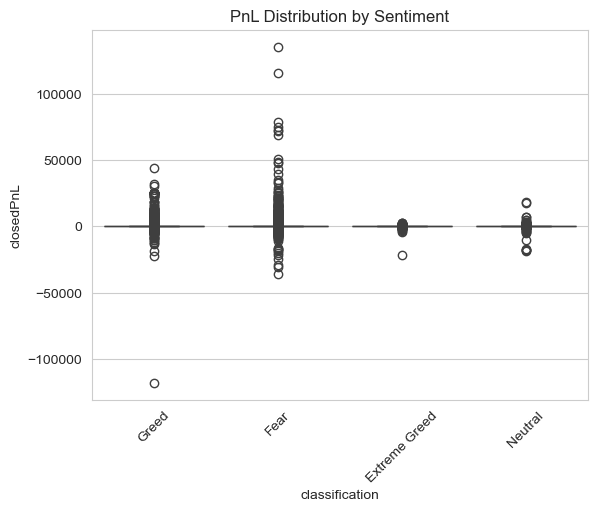

In [36]:
sns.boxplot(x='classification', y='closedPnL', data=df)
plt.title("PnL Distribution by Sentiment")
plt.xticks(rotation=45)
plt.show()

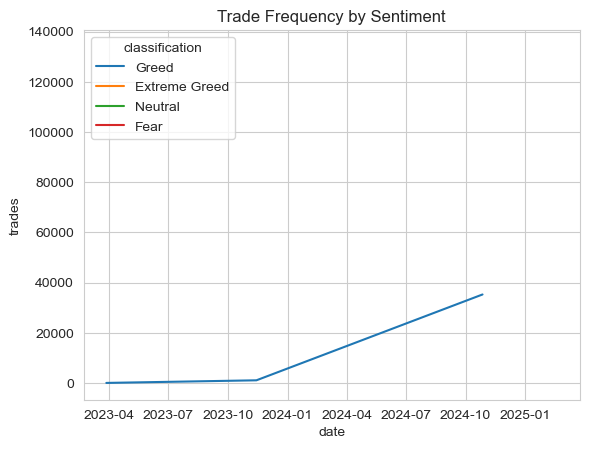

In [37]:
freq = df.groupby(['date','classification']).size().reset_index(name='trades')

sns.lineplot(data=freq, x='date', y='trades', hue='classification')
plt.title("Trade Frequency by Sentiment")
plt.show()

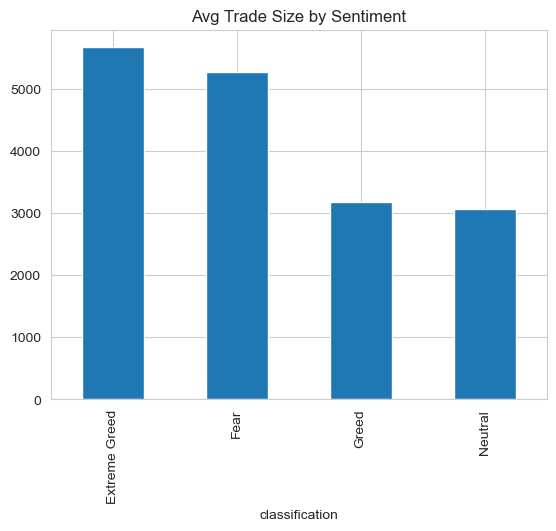

In [38]:
size_analysis = df.groupby('classification')['size'].mean()
size_analysis.plot(kind='bar', title="Avg Trade Size by Sentiment")
plt.show()

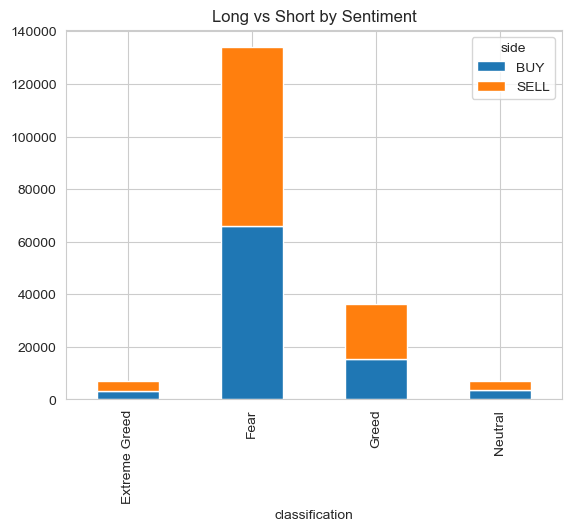

In [39]:
bias = df.groupby(['classification','side']).size().unstack()
bias.plot(kind='bar', stacked=True)
plt.title("Long vs Short by Sentiment")
plt.show()

In [40]:
df['size_cat'] = pd.qcut(df['size'], q=2, labels=['Low','High'])

seg1 = df.groupby(['size_cat','classification'])['closedPnL'].mean().unstack()
print(seg1)

classification  Extreme Greed       Fear       Greed    Neutral
size_cat                                                       
Low                  4.018779   3.233227   12.590597   1.834576
High                39.407556  95.784210  175.718364  49.743021


/var/folders/c6/2288dbr56h12ynwhw_qyzqj80000gn/T/ipykernel_88952/594239050.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg1 = df.groupby(['size_cat','classification'])['closedPnL'].mean().unstack()


In [41]:
trade_counts = df.groupby('account').size()
threshold = trade_counts.median()

df['trader_freq'] = df['account'].apply(
    lambda x: 'Frequent' if trade_counts[x] > threshold else 'Rare'
)

seg2 = df.groupby(['trader_freq','classification'])['closedPnL'].mean().unstack()
print(seg2)

classification  Extreme Greed       Fear       Greed     Neutral
trader_freq                                                     
Frequent            26.658319  46.013950   70.575898    4.055615
Rare               -48.382749  75.639873  234.886424  356.722004


In [42]:
total_pnl = df.groupby('account')['closedPnL'].sum()

df['trader_type'] = df['account'].apply(
    lambda x: 'Winner' if total_pnl[x] > 0 else 'Loser'
)

seg3 = df.groupby(['trader_type','classification'])['closedPnL'].mean().unstack()
print(seg3)

classification  Extreme Greed       Fear       Greed    Neutral
trader_type                                                    
Loser             -206.074672  36.759534  214.290228   2.526527
Winner              26.320044  50.514190   87.261272  22.467067


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

df_model = df.dropna(subset=['size','closedPnL'])

df_model['profit'] = (df_model['closedPnL'] > 0).astype(int)

X = df_model[['size']]
y = df_model['profit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)

print("Model Accuracy:", model.score(X_test, y_test))

Model Accuracy: 0.5981299562078353
